# Ross Ice Shelf, Antarctica

**Station Name:**  lorg

**Location:**  Lorne, Antarctica

**Archive:**  [UNAVCO](http://www.unavco.org)

**DOI:**  [https://doi.org/10.7283/ACF6-YT23](https://doi.org/10.7283/ACF6-YT23)

**Ellipsoidal Coordinates:**

- Latitude:  -78.18365
- Longitude: 170.03361
- Height:  	-7.778 m

[Station Page at UNAVCO](https://www.unavco.org/instrumentation/networks/status/nota/overview/lorg)

[Station Page at Nevada Geodetic Laboratory](http://geodesy.unr.edu/NGLStationPages/stations/LORG.sta)

[Google Maps Link](https://goo.gl/maps/bSAuLXLLMmzWqPdW9) 

<img src="https://gnss-reflections.org/static/images/LORG.jpg" width="500">



### Data Summary

Station lorg is on the Ross Ice Shelf in Antarctica.
The site is a largely featureless ice plain with little to no obstructions. 
It was installed November 2018 and decommissioned and removed in 2019 and it recorded only GPS frequencies during its operation. 

LORG is an example station on the GNSSIR webapp.

### Imports

In [1]:
import os
import sys
import re
import json
import pandas as pd 
import numpy as np
import seaborn as sns; sns.set_theme(style="whitegrid");
import matplotlib.pyplot as plt

# We are including our repository bin to the system path so that we can import the following python modules
bin_path = os.path.abspath(os.path.join('../../bin'))
if bin_path not in sys.path:
    sys.path.append(bin_path)
    
import run_gnssrefl 
import gnssrefl_helpers

%matplotlib inline

In [2]:
#Making sure environment variables are set
exists = gnssrefl_helpers.check_environment()
if exists == False:
    gnssrefl_helpers.set_environment()
else:
     print('environment variable ORBITS path is:\n', os.environ['ORBITS'],
          '\nenvironment variable REFL_CODE path is:\n', os.environ['REFL_CODE'],
          '\nenvironment variable EXE path is:\n', os.environ['EXE'])
        
refl_code_loc = os.environ['REFL_CODE']
# import the crx2rnx file which is dependant on your working OS - this is required to run the gnssrefl code
gnssrefl_helpers.download_crx2rnx()

environment variable ORBITS set to path /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/orbits 
environment variable REFL_CODE set to path /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter 
environment variable EXE set to path /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/bin/exe
downloading CRX2RNX file
file placed in path to execubles set by EXE environment variable
finished


In [3]:
# This is only for these use cases 
# you can set pltscreen=True in quicklook to print these plots as well

def pretty_plots(station, values, frequency,metrics=None):
    # plotting the quicklook graph periodograms
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,10), sharex=True)
    fig.suptitle(f'QuickLook: {station},{frequency}', size=16)

    quadrants = ['NW', 'NE', 'SW', 'SE']
    quadrant_labels = ['Northwest','Northeast', 'Southwest', 'Southeast']

    for i, ax in enumerate(axes.flat):
        quad = quadrants[i]
        for fail_satellite in values[f'f{quad}']:
            g = sns.lineplot(x=values[f'f{quad}'][fail_satellite][0],
                             y=values[f'f{quad}'][fail_satellite][1],
                             ax=ax, color='lightgrey')
        for satellite in values[quad]:
            g = sns.lineplot(x=values[quad][satellite][0],
                             y=values[quad][satellite][1],
                             ax=ax)
        g.set_title(quadrant_labels[i])
        g.set_ylabel('volts/volts')
        g.set_xlabel('reflector height (m)')

    if metrics:
        success, fail = gnssrefl_helpers.quicklook_metrics(metrics)
        fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(10,10), sharex=True)
        fig.suptitle(f'QuickLook Retrieval Metrics: {station}, {frequency}', size=16)

        for i, ax in enumerate(axes):
            g = sns.scatterplot(x='Azimuth',y=success.columns[i+1], data=success, ax=ax, label='good')
            g = sns.scatterplot(x='Azimuth',y=fail.columns[i+1], data=fail, ax=ax, color='lightgrey', label='bad')

        axes[0].legend(loc='upper right')

        avg_rh = np.mean(success['Reflector Height'])
        print(f'Average reflector height value: {avg_rh:.1f}')

    plt.tight_layout()
    plt.show()

## Take a look at the Data


First, we'll make a SNR file. Let's choose day of year 205 in the year 2019 to look at. We'll also save the lat and long information as variables to be used later during analysis.

In [4]:
station = 'lorg'
year = 2019 
doy = 205

lat = -78.1836
long = 170.0336
height = -7.722

In [5]:
run_gnssrefl.rinex2snr(station,year,doy)

SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg2050.19.snr66


Use **quickLook** to produce a periodogram - quickLook is set to use the L1 frequency by default:

minimum elevation angle (degrees) for this dataset:  0.0053
Average reflector height value: 2.1


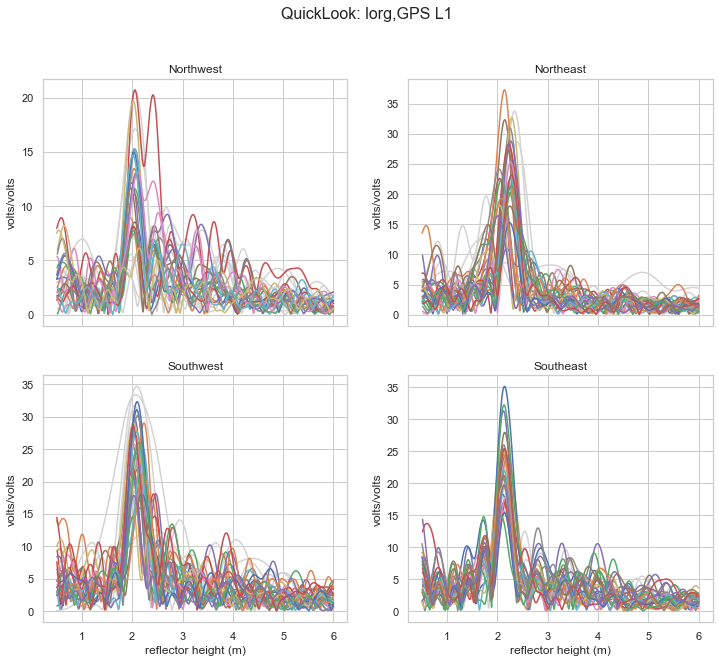

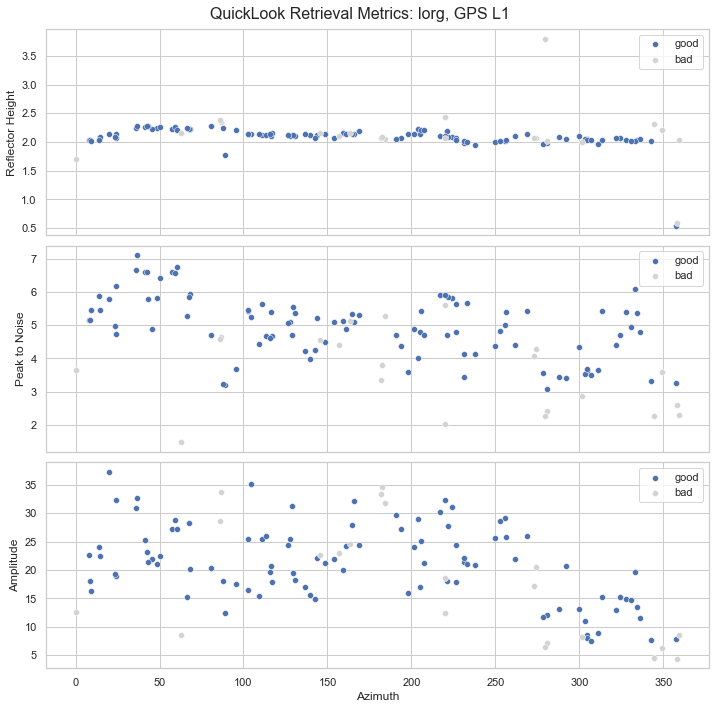

In [6]:
values, metrics = run_gnssrefl.quicklook(station, year, doy=doy)
pretty_plots(station, values, 'GPS L1', metrics)

This looks pretty good. It looks like we will not need an azimuth mask - which makes sense as there are no significant topographic features near the station and so we will use default values for the elevation mask and an azimuth mask is not required.

We will now compare the periodograms for other frequencies: L2C and L5.

This is for L2C:

minimum elevation angle (degrees) for this dataset:  0.0053


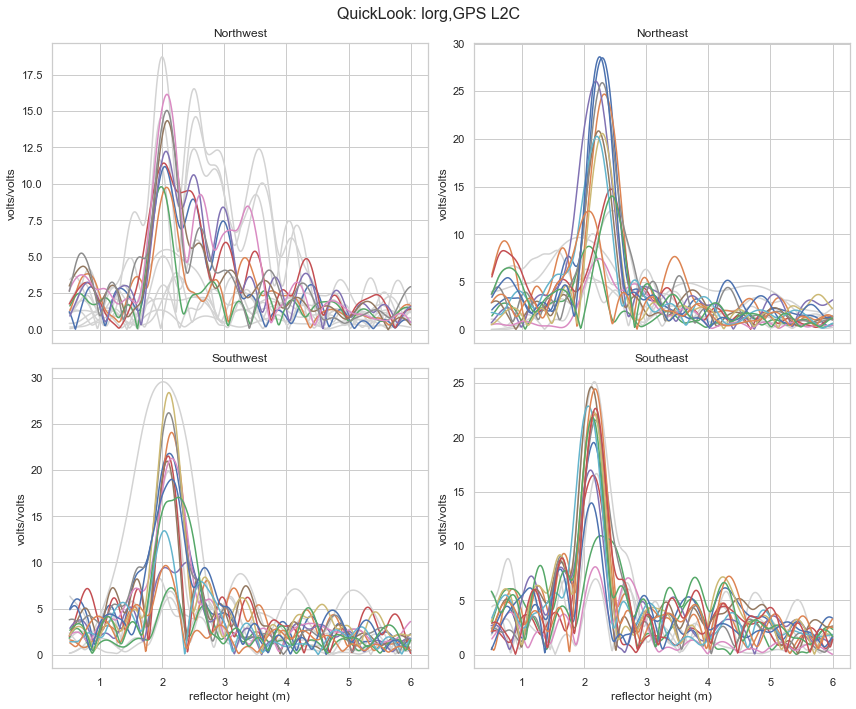

In [9]:
values, metrics = run_gnssrefl.quicklook(station, year, doy=doy, f=20)
pretty_plots(station, values, 'GPS L2C',)

This is for L5:

minimum elevation angle (degrees) for this dataset:  0.0053
Average reflector height value: 2.1


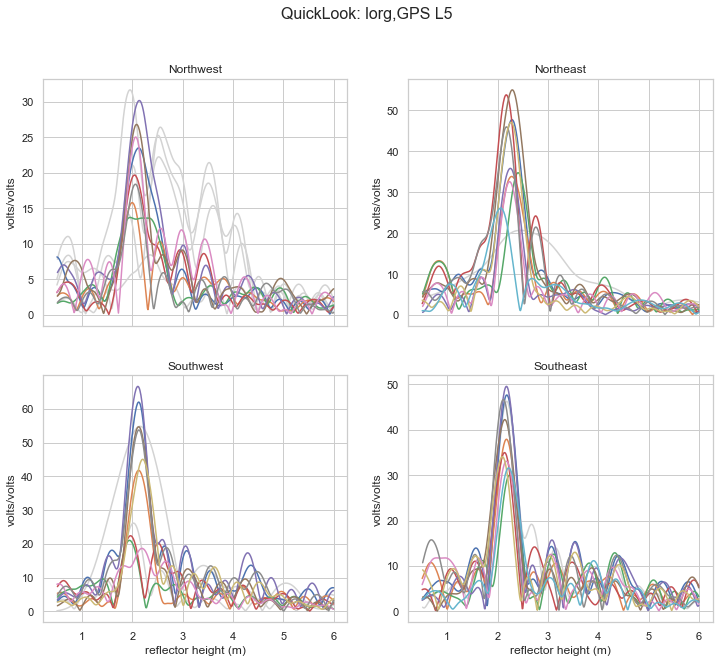

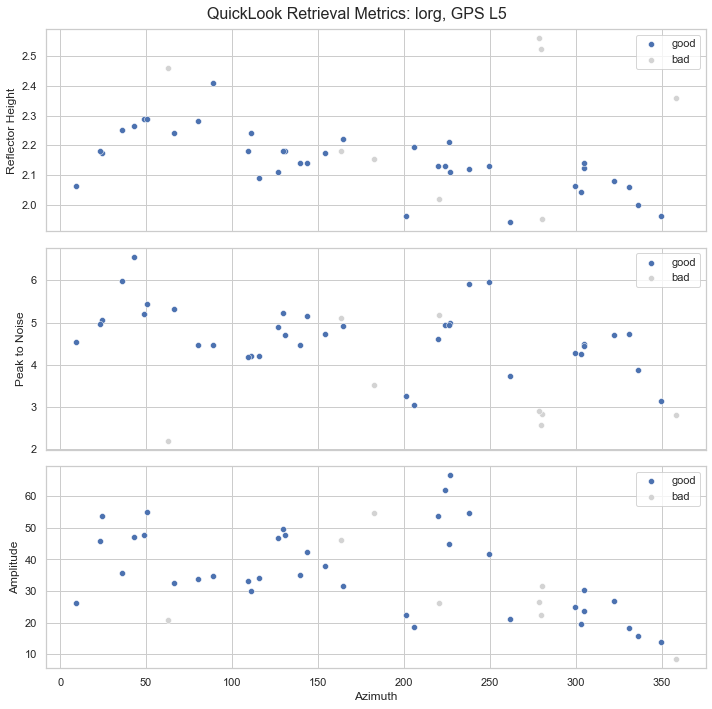

In [10]:
values, metrics = run_gnssrefl.quicklook(station, year, doy=doy, f=5)
pretty_plots(station, values, 'GPS L5', metrics)

They do look pretty similar to the L1 periodogram, except that there
are fewer satellite traces because only GPS satellites launched after 2005
broadcast L2C and only satellites after 2010 broadcast L5.

### Analyze the Data

So now we prepare to analyze the data using **gnssir**.
First ,we create our set of analysis instructions with make json.
The default settings only need the station name, latitude, longitude, and ellipsoidal height.

In [11]:
# we saved the lat, long, and height earlier in the notebook
run_gnssrefl.make_json(station, lat, long, height)

writing out to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/lorg.json


In [12]:
# This is the json file that was created
json_file = f'{refl_code_loc}/input/lorg.json'
with open(json_file, "r") as myfile:
    file = json.load(myfile)

os.remove(json_file)
with open(json_file, 'w') as f:
    json.dump(file, f, indent=4)
    
with open(json_file, "r") as myfile:
    file = json.load(myfile)

file

{'station': 'lorg',
 'lat': -78.1836,
 'lon': 170.0336,
 'ht': -7.722,
 'minH': 0.5,
 'maxH': 6,
 'e1': 5,
 'e2': 25,
 'NReg': [0.5, 6],
 'PkNoise': 2.7,
 'polyV': 4,
 'pele': [5, 30],
 'ediff': 2,
 'desiredP': 0.005,
 'azval': [0, 90, 90, 180, 180, 270, 270, 360],
 'freqs': [1, 20, 5],
 'reqAmp': [6.0, 6.0, 6.0],
 'refraction': None,
 'overwriteResults': True,
 'seekRinex': False,
 'wantCompression': False,
 'plt_screen': False,
 'onesat': None,
 'screenstats': True,
 'pltname': 'lorg_lsp.png',
 'delTmax': 75}

Next make some snr files for a time span of about eight months. We will do day of year 1 through day of year 233 for the year 2019. We can also restrict the search to the UNAVCO archive to make the
code run faster (otherwise it will check other archives as well).

In [ ]:
run_gnssrefl.rinex2snr(station, year=2019, doy=1, doy_end=233, archive='unavco')

We would then run **gnssir** for the same time range. 

In [ ]:
doy = 1
doy_end=233
run_gnssrefl.gnssir(station, year, doy=doy, doy_end=doy_end, screenstats=False)

Then the **daily_avg** command will calculate the daily average reflector height from the daily output files. To minimize outliers in these daily averages, we'll set a median filter to 0.25 meters and the required minimum number of daily satellite tracks we will set to 50.

In [13]:
run_gnssrefl.daily_avg(station, medfilter=.25, ReqTracks=50, plt2screen=False, txtfile='lorg-dailyavg.txt')

all RH will be written to:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/lorg_allRH.txt
Number of files in  2019 233
Daily average RH png file saved as:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/lorg_RH.png
Daily average RH will be written to:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/lorg-dailyavg.txt


This shows the range of reflector heights each day, with each day represented by a different color.

This is not quite perfect - there are some outliers. But it is an great example of how easy it is to use the default code to estimate snow accumulation in Antarctica.

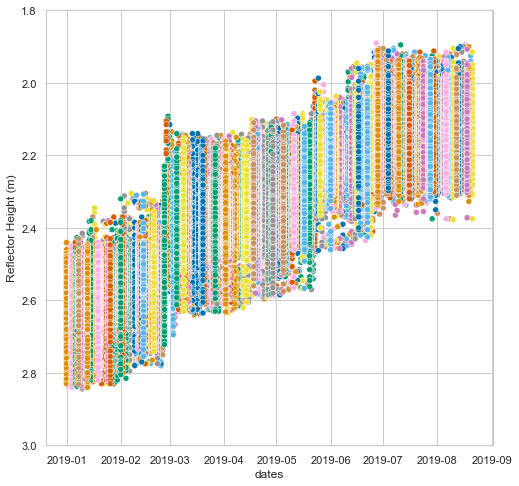

In [14]:
filepath = f'{refl_code_loc}/Files/{station}_allRH.txt'
data = gnssrefl_helpers.read_rh_files(filepath)

df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])
plt.figure(figsize=(8,8))
g = sns.scatterplot(x='dates', y='rh', data=df, hue='dates', palette='colorblind', legend=False)
g.set_ylim(3.0, 1.8)
g.set_ylabel('Reflector Height (m)');

Then the number of values used for the daily average:

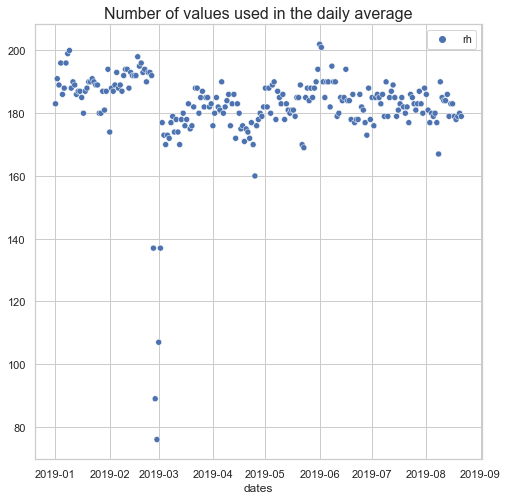

In [15]:
plt.figure(figsize=(8,8))
df_group = df.groupby(['dates']).agg(['count'])
g = sns.scatterplot(data=df_group)
g.set_title('Number of values used in the daily average', size=16);

And then the daily average.

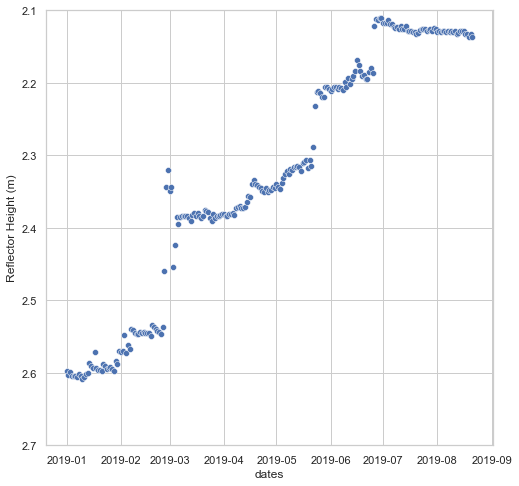

In [16]:
filepath = f'{refl_code_loc}/Files/{station}-dailyavg.txt'
data = gnssrefl_helpers.read_rh_files(filepath)
df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])

plt.figure(figsize=(8,8))
g = sns.scatterplot(x='dates', y='rh', data=df, legend=False)
g.set_ylim(2.7,2.1)
g.set_ylabel('Reflector Height (m)');

These reflector heights then give information about snow accumulation at lorg. 

We have reversed the y-axis so that the reflector height gets smaller as the snow layer increases and the distance between the antenna and snow surface decreases.  